# Classification Data Preparation
**Hunter Estuary KBA, NSW - Change Detection**


Author: Michael Dear, June 2024

This notebook adds classification variables to the dataset.

## Setup

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import xarray as xr
import rioxarray
import numpy as np
import pandas as pd
import geopandas as gpd

# Turn off warnings
import warnings
warnings.filterwarnings('ignore')

### Global Parameters
* Global parameters are used in multiple places
* Local parameters should be found above the relevant code

In [2]:
from global_params import *

# Random state for reproducibility
random_state = 11

y_var = ['class_num']

## Step 1: Load data

In [3]:
ds = xr.load_dataset(netcdf_dir+study_area_abbrev+'.nc')

In [100]:
# Replace NaN with -999
ds = ds.where(ds.notnull(),-999)

In [4]:
mask = xr.load_dataarray(netcdf_dir+'mask.nc')

In [5]:
# Load the polygon
poly = gpd.read_file(vector_dir+study_area_abbrev+'.geojson')

# Set the crs to 4326, then convert to projected crs
# poly = poly.set_crs(4326).to_crs(crs)
poly = poly.to_crs(crs)

In [6]:
# Select the polygon to use
poly = poly[poly['name']=='Buffered 1000m']
poly

,name,description,timestamp,begin,end,altitudemode,tessellate,extrude,visibility,draworder,icon,snippet,geometry
2,Buffered 1000m,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",None,None,None,clampToGround,-1,0,-1,None,None,,MULTIPOLYGON Z (((1814655.723 -3723941.457 0.0...


In [7]:
# Set the crs to 4326, then convert to projected crs
# poly = poly.set_crs(4326).to_crs(crs)
poly = poly.to_crs(crs)

In [8]:
# Put the period names in a list for convenience.
periods = list(ds.period.values)
periods

['Sep 2003', 'Sep 2023']

## Step 2: Kmeans Classification 

#### Imports

In [9]:
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

#### Select the variables to use in the classification

In [10]:
list(ds.data_vars.keys())

['nbart_red',
 'nbart_blue',
 'nbart_green',
 'nbart_nir',
 'nbart_swir_1',
 'nbart_swir_2',
 'NDVI',
 'NBR',
 'NDWI']

In [11]:
# Use all variables if using PCA
km_vars = list(ds.data_vars.keys())

# Use selected variables in not using PCA
# km_vars = [list(ds.data_vars.keys())[i] for i in [0,2,4,8]]
km_vars

['nbart_red',
 'nbart_blue',
 'nbart_green',
 'nbart_nir',
 'nbart_swir_1',
 'nbart_swir_2',
 'NDVI',
 'NBR',
 'NDWI']

#### Create the training sets

In [12]:
# Convert the data array to a data frame
# Re-code nan to -999
dfs = [(ds.sel(period=period)
        # .where(ds.sel(period=period).notnull(), -999)
        .where(mask.notnull())
        .to_dataframe()
        .reset_index()
        .drop(['x','y'], axis=1)[km_vars]
       ) for period in periods]

In [13]:
# Fill NaN with -999
for i in [0,1]:
    print((dfs[i].isnull().sum()))
    print(len(dfs[i]))
    dfs[i] = dfs[i].fillna(-999)
    print((dfs[i].isnull().sum()))
    print(len(dfs[i]))

nbart_red       211657
nbart_blue      211657
nbart_green     211657
nbart_nir       211657
nbart_swir_1    211657
nbart_swir_2    211657
NDVI            211657
NBR             211657
NDWI            211657
dtype: int64
386384
nbart_red       0
nbart_blue      0
nbart_green     0
nbart_nir       0
nbart_swir_1    0
nbart_swir_2    0
NDVI            0
NBR             0
NDWI            0
dtype: int64
386384
nbart_red       211777
nbart_blue      211777
nbart_green     211777
nbart_nir       211777
nbart_swir_1    211777
nbart_swir_2    211777
NDVI            211777
NBR             211777
NDWI            211777
dtype: int64
386384
nbart_red       0
nbart_blue      0
nbart_green     0
nbart_nir       0
nbart_swir_1    0
nbart_swir_2    0
NDVI            0
NBR             0
NDWI            0
dtype: int64
386384


In [14]:
for i in [0,1]:
    print('Period:', i)
    print(dfs[i].head())
    print('--------------')

Period: 0
   nbart_red  nbart_blue  nbart_green  nbart_nir  nbart_swir_1  nbart_swir_2  \
0     -999.0      -999.0       -999.0     -999.0        -999.0        -999.0   
1     -999.0      -999.0       -999.0     -999.0        -999.0        -999.0   
2     -999.0      -999.0       -999.0     -999.0        -999.0        -999.0   
3     -999.0      -999.0       -999.0     -999.0        -999.0        -999.0   
4     -999.0      -999.0       -999.0     -999.0        -999.0        -999.0   

    NDVI    NBR   NDWI  
0 -999.0 -999.0 -999.0  
1 -999.0 -999.0 -999.0  
2 -999.0 -999.0 -999.0  
3 -999.0 -999.0 -999.0  
4 -999.0 -999.0 -999.0  
--------------
Period: 1
   nbart_red  nbart_blue  nbart_green  nbart_nir  nbart_swir_1  nbart_swir_2  \
0     -999.0      -999.0       -999.0     -999.0        -999.0        -999.0   
1     -999.0      -999.0       -999.0     -999.0        -999.0        -999.0   
2     -999.0      -999.0       -999.0     -999.0        -999.0        -999.0   
3     -999.0  

#### Standardise the training data

In [15]:
# scaler = preprocessing.MinMaxScaler()
scaler = preprocessing.StandardScaler()

for df in dfs:
    x = df.values # returns a numpy array
    x_stand = scaler.fit_transform(x)
    df[km_vars] = x_stand
    print(df.head())

   nbart_red  nbart_blue  nbart_green  nbart_nir  nbart_swir_1  nbart_swir_2  \
0  -0.880452   -0.892792    -0.887997  -0.850976     -0.831982      -0.84512   
1  -0.880452   -0.892792    -0.887997  -0.850976     -0.831982      -0.84512   
2  -0.880452   -0.892792    -0.887997  -0.850976     -0.831982      -0.84512   
3  -0.880452   -0.892792    -0.887997  -0.850976     -0.831982      -0.84512   
4  -0.880452   -0.892792    -0.887997  -0.850976     -0.831982      -0.84512   

       NDVI       NBR      NDWI  
0 -0.908581 -0.908581 -0.908581  
1 -0.908581 -0.908581 -0.908581  
2 -0.908581 -0.908581 -0.908581  
3 -0.908581 -0.908581 -0.908581  
4 -0.908581 -0.908581 -0.908581  
   nbart_red  nbart_blue  nbart_green  nbart_nir  nbart_swir_1  nbart_swir_2  \
0  -0.875521   -0.889197    -0.884752  -0.848867     -0.827657     -0.835657   
1  -0.875521   -0.889197    -0.884752  -0.848867     -0.827657     -0.835657   
2  -0.875521   -0.889197    -0.884752  -0.848867     -0.827657     -0.83565

#### (Optional) Apply PCA
Based on https://365datascience.com/tutorials/python-tutorials/pca-k-means/

In [16]:
PCAs = [PCA() for i in [0,1]] 

In [17]:
pca_fit = [pca.fit(dfs[i]) for i, pca in enumerate(PCAs)]

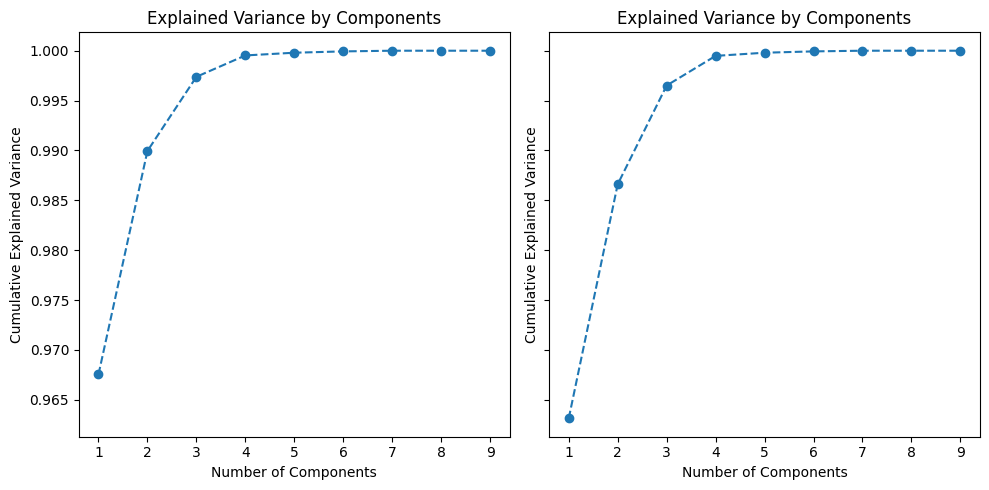

In [18]:
fig, axes = plt.subplots(1,2, figsize=(10,5), sharey=True)
for i, pca in enumerate(pca_fit):
    axes[i].plot(np.arange(1,len(km_vars)+1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
    axes[i].set_title('Explained Variance by Components')
    axes[i].set_xlabel('Number of Components')
    axes[i].set_ylabel('Cumulative Explained Variance')

fig.tight_layout()

In [19]:
# Create PCA with number of components for each period
PCAs = [PCA(n_components=n) for n in [3,3]] 

In [20]:
# Refit with the required number of components
pca_fit = [pca.fit(dfs[i]) for i, pca in enumerate(PCAs)]

In [21]:
# Get the PCA scores
pca_scores = [pca.transform(dfs[i]) for i, pca in enumerate(pca_fit)]

#### Apply Kmeans

In [22]:
ks = np.arange(3,9)

# Set random_state for reproducibility
kms = [KMeans(n_clusters=k, random_state = random_state) for k in ks]

In [23]:
# Sizes for reshaping flattened arrays
w = ds.sizes['y']
l = ds.sizes['x']

#### Fit on all data for each period and each k

In [25]:
# For use with PCA
# %%time
km_fit = [[km.fit(pca_score).labels_.reshape(w,l) for pca_score in pca_scores] for km in kms]

In [26]:
# For use without PCA
# %%time
# km_fit = [[km.fit(df).labels_.reshape(w,l) for df in dfs] for km in kms]

#### Plot

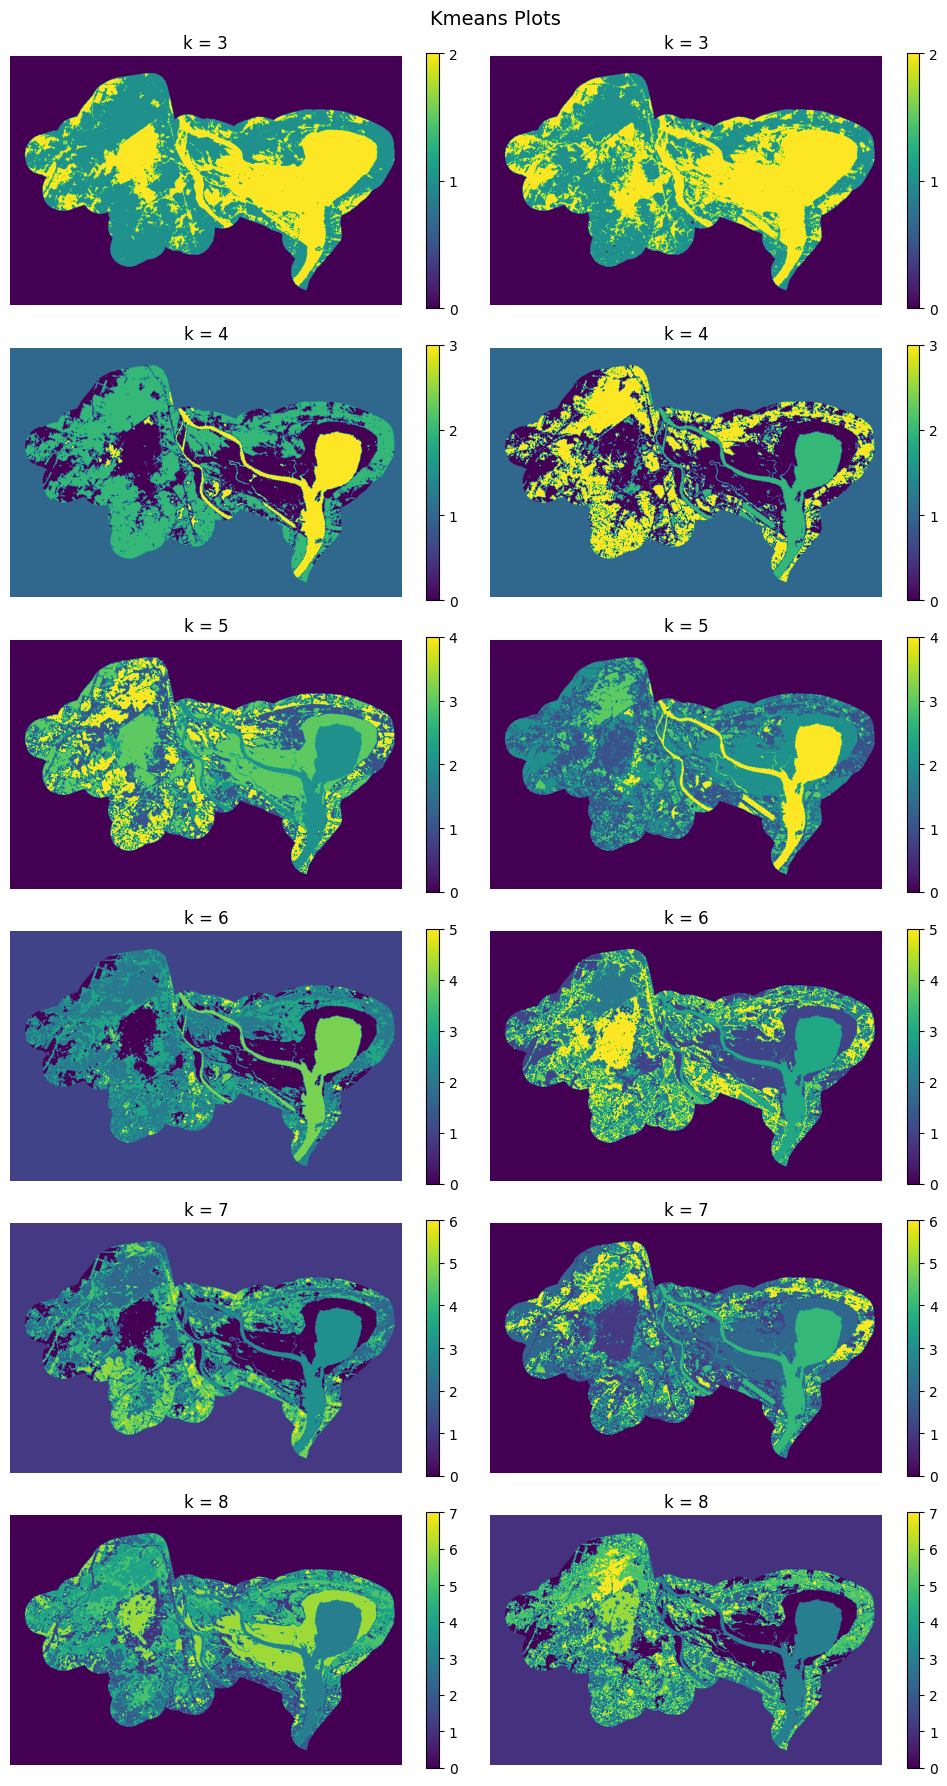

In [27]:
nrow=len(ks)
ncol=2

fig, axes = plt.subplots(nrow, ncol, figsize=(10, nrow*3))

for row in np.arange(nrow):
    for col in np.arange(ncol):
        cl_nums = np.unique(km_fit[row][col])
        ax = axes[row,col]
        color = ax.imshow(km_fit[row][col])
        ax.axis('off')
        ax.set_title('k = '+str(len(cl_nums)))
        cb = plt.colorbar(color)
        cb.set_ticks(cl_nums)

fig.suptitle('Kmeans Plots', y=0.99, fontsize=14);

fig.tight_layout()

fig.savefig(img_dir+'Kmeans_plots_'+periods[0]+'-'+periods[1]+'.png', dpi=600, bbox_inches = "tight");

plt.show()
plt.close('all')

#### Add the classification data to the dataset

In [34]:
km_best=[km_fit[4][0], km_fit[5][1]]

In [35]:
# Convert to int16
km_arrs = np.array(km_best, dtype=np.int16)

In [36]:
ds = ds.assign({'Kmeans_Class': (('period','y','x'), km_arrs)})

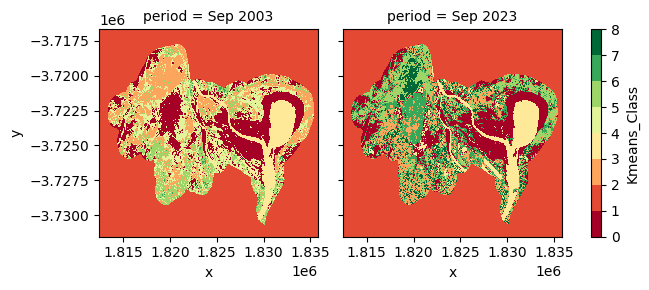

In [37]:
ds.Kmeans_Class.plot(col='period', 
                     levels=np.arange(len(np.unique(ds.Kmeans_Class))+1),
                     cmap='RdYlGn')

#### Re-code Classes (Optional)


In [134]:
old_vals = np.array(km_arrs)

In [135]:
new_vals = np.empty(old_vals.shape)
new_vals.shape

(2, 450, 610)

In [136]:
# Use the same re-code values for both periods if using Option 1.
recode = (
    [(0,2),(1,3),(2,1),(3,0),(4,4)],
    [(0,2),(1,0),(2,3),(3,1),(4,4)]
)

In [137]:
for i in [0,1]:
    for j in np.arange(len(np.unique(old_vals[i]))):
        new_vals[i][old_vals[i]==recode[i][j][0]] = recode[i][j][1]

In [138]:
ds.Kmeans_Class.values = new_vals

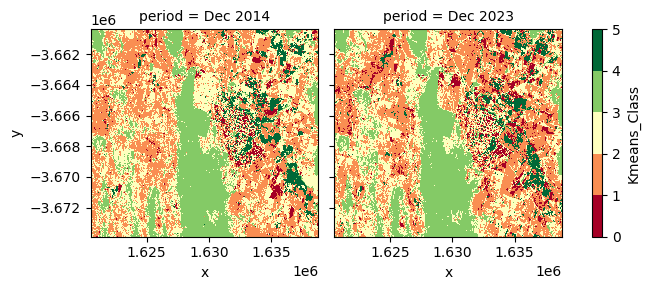

In [139]:
ds.Kmeans_Class.plot(col='period', 
                     levels=np.arange(len(np.unique(ds.Kmeans_Class))+1),
                     cmap='RdYlGn')

## Step 3: Ground-truth Points (GTP)
The process is:
1. Create polygons for each class using QGIS, Google Earth, and composite plots for each period.
2. Intersect the polygons with the data array to create a candidate set of points for each period.
3. Reduce the candidate set in each class to the size of the smallest class.
4. Train the classifier.
5. Predict.

See https://stackoverflow.com/questions/65504116/how-to-convert-a-xarray-dataarray-to-a-geopandas-geodataframe for converting a data array to points.

In [104]:
# Read in the labelled polygons
gtp_polys = [gpd.read_file(vector_dir+'gtp_polygons_'+str(i)+'.geojson').to_crs(crs) for i in [0,1]]

-----
#### (Optional) Apply internal buffer

In [8]:
# Apply internal buffer if required
for i in [0,1]:
    gtp_polys[i]['geometry'] = gtp_polys[i].buffer(-10)

------

In [105]:
for i in [0,1]:
    print(gtp_polys[i].head(6))

   class_num class_name                                           geometry
0          1  Developed  MULTIPOLYGON (((1818773.045 -3724946.683, 1819...
1          4     Wooded  MULTIPOLYGON (((1829994.652 -3723087.513, 1829...
2          0      Water  MULTIPOLYGON (((1831241.476 -3722530.953, 1831...
3          2      Grass  MULTIPOLYGON (((1821821.268 -3723583.199, 1821...
4          3      Swamp  MULTIPOLYGON (((1818670.237 -3723829.411, 1818...
   class_num class_name                                           geometry
0          1  Developed  MULTIPOLYGON (((1818773.045 -3724946.683, 1819...
1          4     Wooded  MULTIPOLYGON (((1829994.652 -3723087.513, 1829...
2          0      Water  MULTIPOLYGON (((1831241.476 -3722530.953, 1831...
3          2      Grass  MULTIPOLYGON (((1821821.268 -3723583.199, 1821...
4          3      Swamp  MULTIPOLYGON (((1818670.237 -3723829.411, 1818...


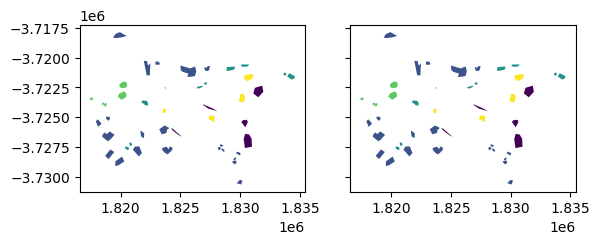

In [106]:
# Plot to check the data
fig, axes = plt.subplots(1,2, sharey=True)
for i in [0,1]:
    unq_nums = np.unique(gtp_polys[i]['class_num'])
    gtp_polys[i].plot(ax=axes[i], column='class_num')

In [107]:
X_vars = list(ds.data_vars.keys())[:9]
X_vars

['nbart_red',
 'nbart_blue',
 'nbart_green',
 'nbart_nir',
 'nbart_swir_1',
 'nbart_swir_2',
 'NDVI',
 'NBR',
 'NDWI']

In [108]:
gtp_base = [[],[]]
thold_var = ''

for i in [0,1]:
    # Convert the data array to a data frame
    df = ds.isel(period=i).to_dataframe().reset_index()
    
    # Convert to a GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x,df.y)).set_crs(crs)

    # Make a bare/water class using NDVI threshold
    if thold_var!='':
        bare = gdf[gdf[thold_var]<= -0.025]
        bare['class_num'] = 0
        bare['class_name'] = 'Water'
    
    # Intersect the points with the polygons
    gdf = gpd.sjoin(gdf, gtp_polys[i], how='inner') # Limit to polygon

    if thold_var!='':
        gtp_base[i] = pd.concat([gdf[X_vars+['class_num','class_name','geometry']], bare[X_vars+['class_num','class_name','geometry']]], axis=0)
    else:
        gtp_base[i] = gdf[X_vars+['class_num','class_name','geometry']]

    gtp_base[i]['class_num'] = gtp_base[i]['class_num'].astype(np.int16)

In [109]:
for i in [0,1]:
    print('Period:', i)
    print(gtp_base[i].head())
    print('--------------')

Period: 0
       nbart_red  nbart_blue  nbart_green  nbart_nir  nbart_swir_1  \
31409      925.0       616.5        882.5     2162.0        1858.5   
32186     1353.0       862.5       1258.0     2622.5        2523.0   
32187     1258.5       829.5       1176.0     2416.0        2283.0   
32188     1088.5       737.5       1022.5     2509.0        2168.0   
32189      961.5       609.0        964.0     2666.0        1956.5   

       nbart_swir_2      NDVI       NBR      NDWI  class_num class_name  \
31409        1321.5  0.401604  0.241461 -0.420670          1  Developed   
32186        1819.0  0.319708  0.181112 -0.353025          1  Developed   
32187        1648.5  0.317121  0.188106 -0.345026          1  Developed   
32188        1506.5  0.397721  0.249430 -0.421755          1  Developed   
32189        1301.5  0.472145  0.343359 -0.470853          1  Developed   

                               geometry  
31409  POINT (1819935.000 -3717885.000)  
32186  POINT (1819875.000 -3717915

#### Count the number of points in each class

In [110]:
# Count the number of points in each class
for i in [0,1]:
    print('Period:', i)
    print(gtp_base[i]['class_num'].value_counts())
    print('--------------')


Period: 0
class_num
1    5156
0    1743
2    1049
4     977
3     769
Name: count, dtype: int64
--------------
Period: 1
class_num
1    5156
0    1743
2    1049
4     977
3     769
Name: count, dtype: int64
--------------


#### (Optional) Combine classes

In [104]:
for i in [0,1]:
    print(periods[i])
    print('============')
    print(gtp_base[i]['class_num'].unique())
    print(gtp_base[i]['class_name'].unique())
    print('--------------')

Dec 2014
[0 1 6 2 4 3 5]
['Bare' 'Developed' 'Brown Crops' 'Grass' 'Dense Wooded' 'Medium Wooded'
 'Green Crops']
--------------
Dec 2023
[0 1 6 2 4 3 5]
['Bare' 'Developed' 'Brown Crops' 'Grass' 'Dense Wooded' 'Medium Wooded'
 'Green Crops']
--------------


In [125]:
for i in [0,1]:
    gtp_base[i]['class_num'][gtp_base[i]['class_num']==0] = 1
    gtp_base[i]['class_name'][gtp_base[i]['class_name']=='Water'] = 'Bare'
    gtp_base[i]['class_num'] = gtp_base[i]['class_num'] - 1

#### Reduce each class to the size of the smallest class

In [111]:
# Reduce each class to the size of the smallest class
sample_size = np.min([gtp_base[i]['class_num'].value_counts().min() for i in [0,1]])

gtp_equal = [pd.concat([gtp_base[i][gtp_base[i]['class_num']==cl].sample(sample_size, random_state=random_state) 
                for cl in gtp_base[i]['class_num'].unique()], axis=0) 
                for i in [0,1]]

In [112]:
# Count the number of points in each class
for i in [0,1]:
    print(periods[i])
    print('============')
    print(gtp_equal[i]['class_num'].value_counts())
    print('--------------')


Sep 2003
class_num
1    769
2    769
4    769
3    769
0    769
Name: count, dtype: int64
--------------
Sep 2023
class_num
1    769
2    769
4    769
3    769
0    769
Name: count, dtype: int64
--------------


In [113]:
# Create the cl_names list
# See https://stackoverflow.com/a/52270276/8299958 for joining pandas columns
cl_num_name = np.char.split(
    (np.unique(gtp_equal[0][['class_num','class_name']]
     .apply(lambda row: ', '.join(row.values.astype(str)), axis=1))
    ).astype(str),
    sep=', '
)
cl_names = [cl_num_name[i][1] for i in np.arange(len(cl_num_name))]
cl_names

['Water', 'Developed', 'Grass', 'Swamp', 'Wooded']

## Step 4: Random Forest
Based on
* https://www.datacamp.com/tutorial/random-forests-classifier-python
* https://www.kaggle.com/code/prashant111/random-forest-classifier-tutorial

#### Imports

In [114]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

#### Create the training and test sets

In [115]:
list(ds.data_vars.keys())

['nbart_red',
 'nbart_blue',
 'nbart_green',
 'nbart_nir',
 'nbart_swir_1',
 'nbart_swir_2',
 'NDVI',
 'NBR',
 'NDWI',
 'Kmeans_Class',
 'RF_Class']

In [116]:
rf_vars = [list(ds.data_vars.keys())[i] for i in np.arange(9)]
rf_vars

['nbart_red',
 'nbart_blue',
 'nbart_green',
 'nbart_nir',
 'nbart_swir_1',
 'nbart_swir_2',
 'NDVI',
 'NBR',
 'NDWI']

In [117]:
X = [gdf[rf_vars] for gdf in gtp_equal]
y = [gdf[y_var] for gdf in gtp_equal]

In [118]:
# Need to use `stratify` to get the same number of samples in each class
# https://stackoverflow.com/a/29477256/8299958
gtp_tt = [train_test_split(X[i], y[i], test_size=0.2, stratify=y[i], random_state=random_state) for i in [0,1]]

In [119]:

pd.DataFrame([[int(len(gtp_tt[i][0])/len(cl_names)),int(len(gtp_tt[i][1])/len(cl_names))] for i in [0,1]],
            columns=['Train', 'Test'],
            index=periods)

,Train,Test
Sep 2003,615,153
Sep 2023,615,153


In [120]:
for i in [0,1]:
    print(gtp_tt[i][0][:5])
    print(gtp_tt[i][2][:5])

        nbart_red  nbart_blue  nbart_green  nbart_nir  nbart_swir_1  \
126030      381.5       246.5        433.0     2051.5         861.0   
293136     1343.5      1019.5       1330.0     2458.0        2363.5   
173885      461.5       280.5        483.0     1980.5        1550.5   
165413      471.5       252.5        429.5     1123.5        1398.5   
226506      422.5       344.5        497.5      254.5         100.0   

        nbart_swir_2      NDVI       NBR      NDWI  
126030         383.5  0.689110  0.684774 -0.655111  
293136        2055.5  0.293305  0.089167 -0.298046  
173885         833.0  0.625026  0.407749 -0.609459  
165413         727.5  0.419522  0.215030 -0.459141  
226506          89.5 -0.296189  0.409982  0.381145  
        class_num
126030          4
293136          1
173885          3
165413          3
226506          0
        nbart_red  nbart_blue  nbart_green  nbart_nir  nbart_swir_1  \
126030      347.0       301.0        430.5     2218.0         918.0   
29313

#### Basic RF

In [121]:
%%time

# List to hold the trained classifiers
rfs = []
# List to hold the accuracies
acc = []
# List to hold the precision and recall data frames
pre_rec = []
# List to hold the confusion matrix data frames
cm = []
# List to hold the feature scores
feat_scores = []


for i in [0,1]:
    # Create and fit the RF classifier
    rf = RandomForestClassifier(random_state=random_state)
    rf.fit(gtp_tt[i][0], gtp_tt[i][2])

    # Append model to list
    rfs.append(rf)
    
    # Predict
    y_pred = rf.predict(gtp_tt[i][1])

    # Assess accuracy, precision, recall
    acc.append(accuracy_score(gtp_tt[i][3], y_pred))
    pre_rec.append(pd.DataFrame({'Precision': precision_score(gtp_tt[i][3], y_pred, average=None),
                               'Recall': recall_score(gtp_tt[i][3], y_pred, average=None)
                              },
                               index=cl_names)
                  )
    
    print(periods[i])
    print('============')
    print('Accuracy =', acc[i])
    print()
    print('Precision and Recall')
    print(pre_rec[i])
    print()
    
    # List the importance of features
    print('Feature Importance')
    feat_scores.append(pd.DataFrame({'Importance':rf.feature_importances_}, index=gtp_tt[i][0].columns))
    print(feat_scores[i])
    print()

    # Confusion matrix
    cm.append(pd.DataFrame(confusion_matrix(gtp_tt[i][3], y_pred),
                           columns = cl_names,
                                  index=cl_names
                          )
             )
    print('Confusion matrix')
    print(cm[i])
    print()

Sep 2003
Accuracy = 0.9869960988296489

Precision and Recall
           Precision    Recall
Water       1.000000  1.000000
Developed   0.967742  0.974026
Grass       0.974359  0.993464
Swamp       0.993333  0.967532
Wooded      1.000000  1.000000

Feature Importance
              Importance
nbart_red       0.058810
nbart_blue      0.061410
nbart_green     0.101504
nbart_nir       0.104114
nbart_swir_1    0.198076
nbart_swir_2    0.178911
NDVI            0.080428
NBR             0.044924
NDWI            0.171823

Confusion matrix
           Water  Developed  Grass  Swamp  Wooded
Water        154          0      0      0       0
Developed      0        150      3      1       0
Grass          0          1    152      0       0
Swamp          0          4      1    149       0
Wooded         0          0      0      0     154

Sep 2023
Accuracy = 0.9973992197659298

Precision and Recall
           Precision    Recall
Water       1.000000  1.000000
Developed   1.000000  0.993506
Grass     

In [122]:
# For copying to the report
cm[0]
# cm[1]

,Water,Developed,Grass,Swamp,Wooded
Water,154,0,0,0,0
Developed,0,150,3,1,0
Grass,0,1,152,0,0
Swamp,0,4,1,149,0
Wooded,0,0,0,0,154


#### RF With Hyperparameter Tuning
*Warning*: This will take a long time to complete.

In [488]:
%%time

# List to hold the trained classifiers
rfs = []

for i in [0,1]:
    # Create the parameter grid
    param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

    # Create a random forest classifier
    rf = RandomForestClassifier(random_state=random_state)
    
    # Use random search to find the best hyperparameters
    rand_search = RandomizedSearchCV(rf, 
                                     param_distributions = param_dist, 
                                     n_iter=5, 
                                     cv=5)

    # Split the data into training and test sets
    # X_train, X_test, y_train, y_test = train_test_split(X[i], y[i], test_size=0.2, random_state=random_state)
   
    # Fit the random_search to the data
    rand_search.fit(gtp_tt[i][0], gtp_tt[i][2])

    # Store the best model
    best_rf = rand_search.best_estimator_

    # Predict
    y_pred = best_rf.predict(gtp_tt[i][1])
    accuracy = accuracy_score(gtp_tt[i][3], y_pred)

    # Append best model to list
    rfs.append(best_rf)

    print(periods[i])
    print('============')
    # print('y_test:', y_test['class'].values)
    # print('y_pred:', y_pred)
    print("Accuracy:", accuracy)
    print()

    # List the importance of features
    print('Feature Importance')
    feature_scores = pd.Series(best_rf.feature_importances_, index=gtp_tt[i][0].columns).sort_values(ascending=False)
    print(feature_scores)
    print()

    # Confusion matrix
    cm = confusion_matrix(gtp_tt[i][3], y_pred)
    print('Confusion matrix')
    print(cm)
    print()

Jul 2015
Accuracy: 0.938006723353767

Feature Importance
nbart_swir_2    0.245012
nbart_red       0.238164
nbart_swir_1    0.156639
nbart_green     0.133209
NDVI            0.118846
nbart_blue      0.075049
nbart_nir       0.033079
dtype: float64

Confusion matrix
[[  88    4   79    3]
 [   0  304  244    2]
 [  10   84 2573  133]
 [   0    0   68 6522]]



KeyboardInterrupt: 

#### Predictions for each period

In [123]:
rf_arrs = [[] for i in [0,1]]

In [124]:
# Sizes for reshaping flattened arrays
w = ds.sizes['y']
l = ds.sizes['x']

In [125]:
%%time
rf_arrs = [rfs[i].predict(ds.sel(period=periods[i]).to_dataframe()[rf_vars].values).reshape(w,l) for i, period in enumerate(periods)]

CPU times: total: 6.41 s
Wall time: 7.49 s


#### Add the classification data to the dataset

In [126]:
ds = ds.assign({'RF_Class': (('period','y','x'), rf_arrs)})

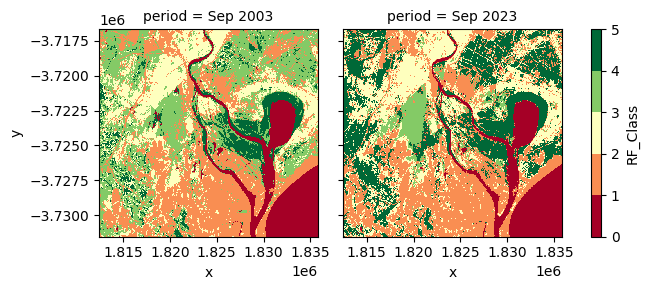

In [127]:
ds.RF_Class.plot(col='period', 
                 levels=np.arange(len(np.unique(ds.RF_Class))+1),
                 cmap='RdYlGn')

## Step 4: Export data 

### netCDF

In [128]:
# Save as netCDF
ds.to_netcdf(netcdf_dir+study_area_abbrev+'.nc')

### GeoTIFF - Time steps

Each year is saved with all variables in a geoTIFF file.

**Note**: Converting `to_array()` is essential to avoid "ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''" error.  


In [129]:
for period in ds.period.values:
     (ds
     .sel(period=period)
     .to_array() # Essential!
     .rio.to_raster(geotiff_dir+study_area_abbrev+'_'+str(period)+'.tiff')
     )

In [ ]:
# Single variable
class_var = 'RF_Class'
for period in ds.period.values:
     (ds[class_var]
     .sel(period=period)
     # .to_array() # Essential!
     .rio.to_raster(geotiff_dir+study_area_abbrev+'_'+str(period)+'_'+class_var+'.tiff')
     )

---------

In [130]:
ds

<xarray.Dataset>
Dimensions:       (period: 2, y: 496, x: 779)
Coordinates:
  * y             (y) float64 -3.717e+06 -3.717e+06 ... -3.732e+06 -3.732e+06
  * x             (x) float64 1.812e+06 1.812e+06 ... 1.836e+06 1.836e+06
    spatial_ref   int32 3577
  * period        (period) <U8 'Sep 2003' 'Sep 2023'
Data variables:
    nbart_red     (period, y, x) float32 752.5 693.5 692.5 ... 176.0 176.5 175.0
    nbart_blue    (period, y, x) float32 397.5 355.5 367.0 ... 387.5 388.5 389.0
    nbart_green   (period, y, x) float32 659.5 624.5 630.5 ... 305.5 304.0 303.0
    nbart_nir     (period, y, x) float32 2.076e+03 2.06e+03 ... 124.5 125.5
    nbart_swir_1  (period, y, x) float32 2.264e+03 1.94e+03 ... 53.0 53.5
    nbart_swir_2  (period, y, x) float32 1.315e+03 1.072e+03 ... 39.5 41.5
    NDVI          (period, y, x) float32 0.4719 0.5012 ... -0.1865 -0.1794
    NBR           (period, y, x) float32 0.2247 0.3167 0.3166 ... 0.5354 0.5104
    NDWI          (period, y, x) float32 -0.5204 -0.5371 ... 0.4309 0.4268
    Kmeans_Class  (period, y, x) int16 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    RF_Class      (period, y, x) int16 3 3 3 3 3 3 3 3 3 3 ... 0 0 0 0 0 0 0 0 0